# Final Prediction Model + Application Example

### Import libraries

In [83]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score, precision_score, roc_auc_score, plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import lightgbm as lgb

import joblib
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

### Define the prediction Model and the Features Transformers
**Note:** Due to the existing of a Sampler (UnderSampling) in between pre-processing and prediction modeling, we have to create two `scikit-learn Pipelines` : 
- First Pipeline is regrouping the trasnformers in the following order: Age encoding, Onehot encoding for all columns & SelectKbest.
- Second Pipeline contains the first Pipeline and the prediction model.

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
WGM score for trainset :  0.6841290520291708
WGM score for testset  :  0.6146844463578309
AUC score for testset  :  0.6955070379391131


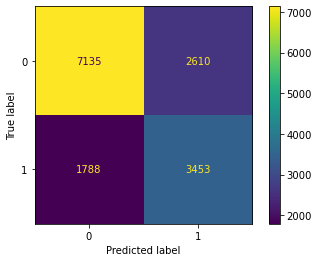

In [107]:
#Define customized scorer: 
def Weigthed_geometric_mean(y, y_pred, Beta=1.1):
    recall= recall_score(y, y_pred, pos_label=1)
    precision= precision_score(y, y_pred, pos_label=1)
    return (precision * (recall**Beta))**(1/(1+Beta))

#import dataset
df= pd.read_csv('data/bicycle_accidents_05_20_filtered.csv', sep=';',squeeze=True, parse_dates={'date':['an','mois','jour','hrmn']} )

#define features and target
X= df.drop(['date','grav'],1).copy()
y= df.grav.copy().replace([[1,4],[2,3]], [0,1])

#split to train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 42, shuffle=True, stratify=y )

#Transformers
##age encoding

class age_encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['age'] = pd.cut(X.age, bins=[0,12,20,40,60,99], labels=[1,2,3,4,5] )
        return X
        
age_col= ColumnTransformer([('age',age_encoder(), [-1])], remainder='passthrough')

##Regroup transformers
transformers_pipe= Pipeline(steps=[
    ('age', age_col),
    ('onhot', OneHotEncoder(handle_unknown='ignore')),
    ('kbest', SelectKBest(k=60))
]).fit(X_train, y_train)

X_train= transformers_pipe.transform(X_train)

#Sample Train features
sampler= RandomUnderSampler()
X_train, y_train= sampler.fit_resample(X_train, y_train)

#Define model
best_params =  {'feature_fraction': 0.4, 'learning_rate': 0.07, 'max_depth': -1000,
                    'num_leaves': 17, 'verbose': -1, 'objective':'binary'}
model= lgb.LGBMClassifier(**best_params).fit(X_train,y_train)

#Define Pipeline regrouping all steps (each element is already fitted)
final_pipe=Pipeline(steps=[
    ('transformers', transformers_pipe),
    ('estimator', model)
])

#Save Pipeline
joblib.dump(final_pipe, 'Full_Model.pkl')

y_train_pred = model.predict(X_train)
y_test_pred = final_pipe.predict(X_test)

#Evaluation
print("WGM score for trainset : ", Weigthed_geometric_mean(y_train, y_train_pred))
print("WGM score for testset  : ", Weigthed_geometric_mean(y_test,y_test_pred))
print("AUC score for testset  : ", roc_auc_score(y_test,y_test_pred))
plot_confusion_matrix(final_pipe, X_test, y_test, values_format='d');

### Application: 

**Calculate the dangerousness of the possible trajectories between `'Charles de Gaule Etoile station'` & `'LOUIS VUITTON Foundation'` in Paris.**

In [116]:
#Import dataset that contains 2 possible trajectories, each line is a step in the trajectory
df= pd.read_csv('data/db_test_1.csv', sep=';',squeeze=True )

#trajectory 1
X1= df.iloc[0:43]

#trajectory 2
X2=df.iloc[43:]

#apply model

def get_danger(X, clf):
    y = clf.predict(X)
    danger= y.sum()/len(y)
    return danger

clf= joblib.load('Full_Model.pkl')

danger1= get_danger(X1, clf)
danger2= get_danger(X2, clf)

print("Dangerousness of first itinerary  : ", round(danger1,2))
print("Dangerousness of second itinerary  : ", round(danger2,2))


Dangerousness of first itinerary  :  0.19
Dangerousness of second itinerary  :  0.29
